In [13]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

In [15]:
import FinanceDataReader as fdr

In [26]:
# 삼성 주가
samsung = fdr.DataReader('005930','1990-01-01', '2019-12-30')
# 데이터를 DataFrame으로 가져오기

In [27]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2019-12-23,56100,56400,55100,55500,9839252,-0.0089
2019-12-24,55600,55700,54800,55000,11868463,-0.0090
2019-12-26,54700,55400,54400,55400,9645034,0.0073
2019-12-27,55700,56900,55500,56500,12313056,0.0199
2019-12-30,56200,56600,55700,55800,8356767,-0.0124


In [23]:
STOCK_CODE = '005930'

In [24]:
stock = fdr.DataReader(STOCK_CODE)

In [28]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-08-11,803,832,787,788,424400,NaN
1998-08-12,781,781,759,775,485370,-0.0165
1998-08-13,774,791,754,763,514440,-0.0155
1998-08-14,756,758,724,753,500090,-0.0131
1998-08-17,750,771,741,755,317040,0.0027


Text(0, 0.5, 'price')

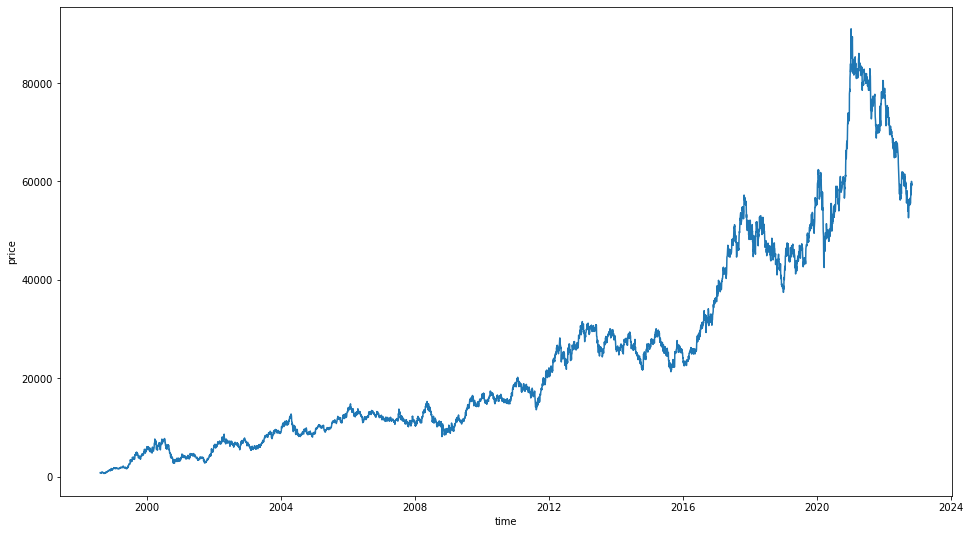

In [29]:
#시각화
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

In [30]:
# 데이터 전처리
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.00889258, 0.00859504, 0.0087933 , 0.00165999, 0.00469957],
       [0.00864895, 0.00806818, 0.00848045, 0.00151612, 0.00537472],
       [0.00857143, 0.00817149, 0.00842458, 0.00138332, 0.00569662],
       ...,
       [0.66112957, 0.61983471, 0.66256983, 0.6525088 , 0.14620173],
       [0.64894795, 0.6177686 , 0.64916201, 0.64808216, 0.1936984 ],
       [0.65448505, 0.61466942, 0.65251397, 0.65029548, 0.13749703]])

In [31]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [32]:
#train / test 분할
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [33]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [34]:
x_train

,Open,High,Low,Volume
0,0.0089,0.0086,0.0088,0.0047
1,0.0086,0.0081,0.0085,0.0054
2,0.0086,0.0082,0.0084,0.0057
3,0.0084,0.0078,0.0081,0.0055
4,0.0083,0.0080,0.0083,0.0035
...,...,...,...,...
4795,0.5739,0.5382,0.5772,0.0019
4796,0.5770,0.5382,0.5709,0.0025
4797,0.5683,0.5401,0.5705,0.0045
4798,0.5674,0.5318,0.5645,0.0033


In [35]:
#TensroFlow Dataset을 활용한 시퀀스 데이터셋
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [36]:
#Hyperparameter
WINDOW_SIZE=20
BATCH_SIZE=32

In [37]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [38]:
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [39]:
#모델링
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])


In [40]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [41]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈추기.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [42]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    149/Unknown - 10s 25ms/step - loss: 1.0541e-04 - mse: 2.1083e-04
Epoch 1: val_loss improved from inf to 0.00067, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 13s 46ms/step - loss: 1.0543e-04 - mse: 2.1087e-04 - val_loss: 6.6777e-04 - val_mse: 0.0013
Epoch 2/50
147/150 [============================>.] - ETA: 0s - loss: 2.6735e-05 - mse: 5.3469e-05
Epoch 2: val_loss improved from 0.00067 to 0.00041, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 3s 19ms/step - loss: 2.7775e-05 - mse: 5.5549e-05 - val_loss: 4.1233e-04 - val_mse: 8.2466e-04
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 2.4960e-05 - mse: 4.9921e-05
Epoch 3: val_loss improved from 0.00041 to 0.00032, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 3s 17ms/step - loss: 2.4960e-05 - mse: 4.9921e-05 - val_loss: 3.2450e-04 - val_mse: 6.4901e-04
Epoch 4/50
149/150 [=========================

In [43]:
#저장한 ModelCheckpoint 를 로드
model.load_weights(filename)

In [44]:
#test_data를 활용해서 예측
pred = model.predict(test_data)

37/37 [==============================] - 1s 7ms/step


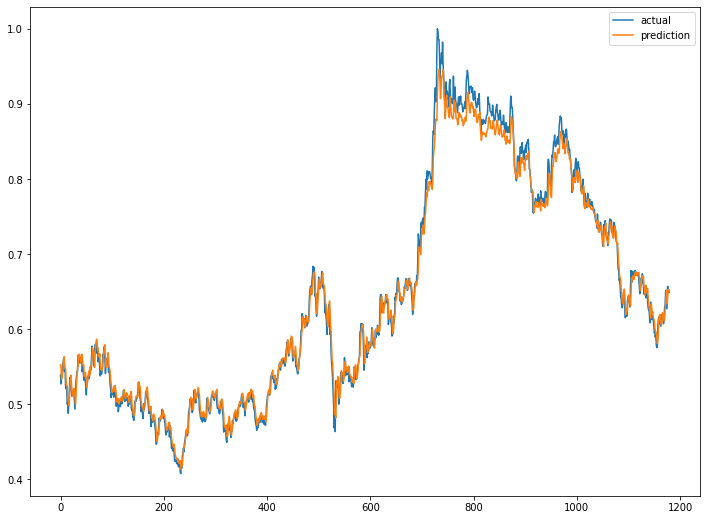

In [45]:
#예측 데이터 시각화
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()